Load the forecasts

In [1]:
import pandas as pd

reverse_station_mapping = {
    433: 10384, 2667: 10513, 3379: 10865, 1443: 10803, 
    5906: 10729, 2522: 10727, 4104: 10776, 1270: 10554, 
    5419: 10555
}

valid_stations = [
    reverse_station_mapping[station] for station in [433, 1270, 1443, 2667, 3379, 4104, 5906]
]

df_forecasts = pd.read_csv("/Users/fohlen/Downloads/export_2024-11-08/merged.csv")
df_forecasts = df_forecasts[df_forecasts["station_id"].isin(valid_stations)]
df_forecasts["recorded_at"] = pd.to_datetime(df_forecasts["recorded_at"], utc=True)
df_forecasts["recorded_at"] = df_forecasts["recorded_at"].dt.floor('h')
df_forecasts["forecast_time"] = pd.to_datetime(df_forecasts["forecast_time"], utc=True)
df_forecasts.head()

,recorded_at,station_id,forecast_time,parameter,value
0,2024-05-12 15:00:00+00:00,10513,2024-05-12 15:00:00+00:00,precipitation_height_significant_weather_last_1h,0.0
1,2024-05-12 15:00:00+00:00,10513,2024-05-12 16:00:00+00:00,precipitation_height_significant_weather_last_1h,0.0
2,2024-05-12 15:00:00+00:00,10513,2024-05-12 17:00:00+00:00,precipitation_height_significant_weather_last_1h,0.0
3,2024-05-12 15:00:00+00:00,10513,2024-05-12 18:00:00+00:00,precipitation_height_significant_weather_last_1h,0.0
4,2024-05-12 15:00:00+00:00,10513,2024-05-12 19:00:00+00:00,precipitation_height_significant_weather_last_1h,0.0


Load the actual weather

In [3]:
df_measure = pd.read_csv("/Users/fohlen/PycharmProjects/weather_experiment/data/historical_weather.csv")
df_measure["recorded_at"] = pd.to_datetime(df_measure["recorded_at"], utc=True)
df_measure.head()

,recorded_at,station_id,parameter,value
0,2024-05-06 00:00:00+00:00,433,precipitation_height,0.0
1,2024-05-06 01:00:00+00:00,433,precipitation_height,0.0
2,2024-05-06 02:00:00+00:00,433,precipitation_height,0.0
3,2024-05-06 03:00:00+00:00,433,precipitation_height,0.0
4,2024-05-06 04:00:00+00:00,433,precipitation_height,0.0


Mapping from forecast to measurement

In [4]:
reverse_parameter_mapping = {
    'precipitation_height': 'precipitation_height_significant_weather_last_1h',
    'temperature_air_mean_2m': 'temperature_air_mean_200'
}

We calculate the average value over all forecasts over all stations. 

In [10]:
from tqdm import tqdm
from tqdm.contrib.concurrent import thread_map

parameter = "temperature_air_mean_2m"
rows = df_measure[
  (df_measure["parameter"] == parameter)
]

measure_times = rows.recorded_at.unique().tolist()

def average_forecast_time(measure_time):
    forecast_rows_measure_time = df_forecasts[
        (df_forecasts["forecast_time"] == measure_time) &
        (df_forecasts["parameter"] == reverse_parameter_mapping[parameter])
    ]

    return forecast_rows_measure_time.groupby(forecast_rows_measure_time.recorded_at).value.mean().mean()

rows_measure_time = thread_map(average_forecast_time, measure_times)

#for measure_time in tqdm(measure_times):
#    forecast_rows_measure_time = df_forecasts[
#        (df_forecasts["forecast_time"] == measure_time) &
#        (df_forecasts["parameter"] == reverse_parameter_mapping[parameter])
#    ]

#    rows_measure_time.append(forecast_rows_measure_time.groupby(forecast_rows_measure_time.recorded_at).value.mean().mean())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4417/4417 [29:11<00:00,  2.52it/s]


Since running preprocessing takes thirthy minutes, we'll persist the results to disk:

In [51]:
import numpy as np

X_sun = np.array(rows_measure_time)
y_sun = np.array([
    rows[rows.recorded_at == measure_time].value.mean()
    for measure_time in measure_times
])

np.save("/Users/fohlen/PycharmProjects/weather_experiment/data/forecasts_sun.npy", X_sun)
np.save("/Users/fohlen/PycharmProjects/weather_experiment/data/measures_sun.npy", y_sun)

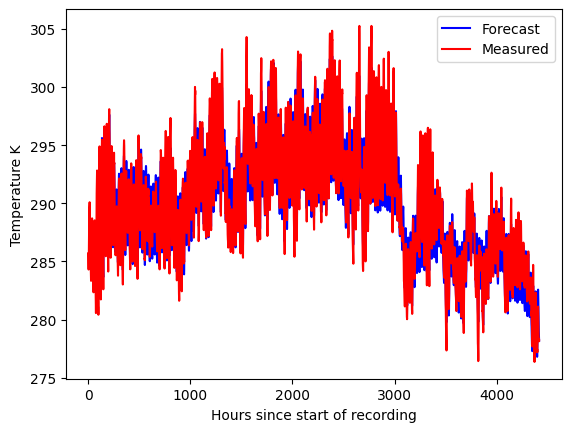

In [54]:
import matplotlib.pyplot as plt

plt.plot(X_sun, c="b", label="Forecast")
plt.plot(y_sun, c="r", label="Measured")
plt.xlabel("Hours since start of recording")
plt.ylabel("Temperature K")
plt.legend()
plt.savefig("forecast_vs_real_sun.png")
plt.show()

In [38]:
from scipy import stats

nonzero_elements = np.count_nonzero(~np.isnan(X_sun))
skip = X_sun.shape[0] - nonzero_elements

stats.linregress(X_sun[skip:], y_sun[skip:])

LinregressResult(slope=1.0328078601355117, intercept=-9.280168156019784, rvalue=0.9746191431121498, pvalue=0.0, stderr=0.003626248183114254, intercept_stderr=1.0517393242304474)

In [60]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

clf = LinearRegression()
scores_sun_lr = cross_val_score(clf, X_sun[skip:].reshape(-1, 1), y_sun[skip:], cv=10)

In [45]:
from statistics import mean

print(scores_sun_lr)
print(mean(scores_sun_lr))

[0.92660136 0.86684381 0.87677871 0.91550055 0.89445206 0.91040872
 0.93109846 0.90530554 0.85273834 0.82862337]
0.8908350915573653


In [46]:
from sklearn.linear_model import Ridge

clf_ridge = Ridge()
scores_sun_ridge = cross_val_score(clf, X_sun[skip:].reshape(-1, 1), y_sun[skip:], cv=10)

In [47]:
print(scores_sun_ridge)
print(mean(scores_sun_ridge))

[0.92660136 0.86684381 0.87677871 0.91550055 0.89445206 0.91040872
 0.93109846 0.90530554 0.85273834 0.82862337]
0.8908350915573653


Repeat for rain:

In [48]:
parameter = "precipitation_height"
rows_rain = df_measure[
  (df_measure["parameter"] == parameter)
]

measure_times = rows.recorded_at.unique().tolist()

def average_forecast_time(measure_time):
    forecast_rows_measure_time = df_forecasts[
        (df_forecasts["forecast_time"] == measure_time) &
        (df_forecasts["parameter"] == reverse_parameter_mapping[parameter])
    ]

    return forecast_rows_measure_time.groupby(forecast_rows_measure_time.recorded_at).value.mean().mean()

rows_measure_time_rain = thread_map(average_forecast_time, measure_times)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4417/4417 [29:10<00:00,  2.52it/s]


In [52]:
X_rain = np.array(rows_measure_time_rain)
y_rain = np.array([
    rows_rain[rows_rain.recorded_at == measure_time].value.mean()
    for measure_time in measure_times
])

np.save("/Users/fohlen/PycharmProjects/weather_experiment/data/forecasts_rain.npy", X_rain)
np.save("/Users/fohlen/PycharmProjects/weather_experiment/data/measures_rain.npy", y_rain)

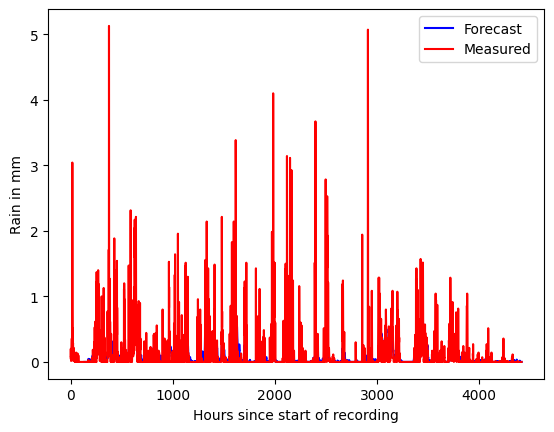

In [56]:
import matplotlib.pyplot as plt

plt.plot(X_rain, c="b", label="Forecast")
plt.plot(y_rain, c="r", label="Measured")
plt.xlabel("Hours since start of recording")
plt.ylabel("Rain in mm")
plt.legend()
plt.savefig("forecast_vs_real_rain.png")
plt.show()

In [57]:
stats.linregress(X_rain[skip:], y_rain[skip:])

LinregressResult(slope=1.3511753553172967, intercept=0.018716270064699295, rvalue=0.43866602103081076, pvalue=6.48120081645971e-201, stderr=0.0423103379915553, intercept_stderr=0.005617245126614284)

In [61]:
clf_rain = LinearRegression()
scores_rain_lr = cross_val_score(clf_rain, X_rain[skip:].reshape(-1, 1), y_rain[skip:], cv=10)

In [62]:
print(scores_rain_lr)
print(mean(scores_rain_lr))

[ 0.22997627  0.31787177  0.16157666  0.04235106  0.09054007  0.22938198
  0.02155495  0.30763723  0.24352251 -0.08956446]
0.15548480539947063


In [63]:
clf_rain_ridge = Ridge()
scores_rain_ridge = cross_val_score(clf_rain_ridge, X_rain[skip:].reshape(-1, 1), y_rain[skip:], cv=10)

In [64]:
print(scores_rain_ridge)
print(mean(scores_rain_ridge))

[ 0.22762109  0.31386427  0.16423048  0.04556391  0.08963913  0.22668467
  0.02821872  0.31235394  0.24305629 -0.12656817]
0.15246643245051072
